# Coursework Assignment: Text classification

# 1. Introduction

## Domain-Specific Area: Hate speech recognition on social medias

The internet has allowed all kinds of people to express themselves and receive recognition for what they express. While this might seem beneficial to many, it has also brought some drawbacks.

It has allowed people to say whatever they want in a 'more anonymous' manner, including harmful things. There are few to no consequences for those who publish inappropriate content on the internet.

According to the [research](https://doi.org/10.1016/j.copsyc.2021.12.010) titled "Social Media and Online Hate," "The proliferation of hate online has become recognized as one of the biggest challenges to social media industries: ‘throughout 2020 and early 2021, major technology companies announced that they were taking unprecedented action against the hate speech, harassment … that had long flourished on their platforms … (yet) the level of online hate and harassment reported by users barely shifted’. Online hate is pervasive: surveys across several countries indicate that 42%–67% of young adults observed ‘hateful and degrading writings or speech online’, and 21% have been victims themselves".

Because of this, social media platforms have implemented hate content detection features in their software to remove this content and provide a safer environment, enhancing user experience.

Hate speech detection is challenging because it involves differentiating between hate and non-hate speech. Fortunately, we can use NLP techniques such as text classification. We will use two classifiers to achieve this and compare their performances.

## Objectives


We will build and compare the performance of two classifiers. By doing so, we can determine which model is more accurate and appropriate for detecting hate speech content.

### Statistical

We'll use the Naive Bayes algorithm to build a text classification model. According to [GeeksForGeeks](https://www.geeksforgeeks.org/how-to-generate-word-embedding-using-bert), 'The advantage of using Naive Bayes is its speed. It is fast, and making predictions is easy with high-dimensional data'. Statistical models are generally simpler to implement and interpret compared to embedding-based models.

### Embedding-based 

We'll use a recurrent neural network (RNN), a powerful model for sequential data like text, to build our second classifier. RNNs is great at capturing dependencies over sequences but demand more computational resources and often require larger datasets for effective training.


## Dataset description

The dataset I'll be using is called Ethos. It is short for multi-labEl haTe speecH detectiOn dataSet. The contributors are Grigorios Tsoumakas, Ioannis Mollas, Zoe Chrysopoulou, and Stamatis Karlos. Their pre-print paper can be found [here](https://doi.org/10.1007/s40747-021-00608-2).

It has two variants: multi-label and binary. However, only the binary variant will be necessary for this case.

The file is 124 KB in size. It contains 998 comments along with a label indicating the presence or absence of hate speech. Of these, 565 do not contain hate speech, while the remaining 433 do.

The first column contains strings (comments), and the second contains integers/booleans (0 or 1).

The comments were extracted from YouTube and Reddit and validated using the [Figure-Eight](https://aws.amazon.com/financial-services/partner-solutions/figure-eight/) crowdsourcing platform.

## Evaluation Methodology

To properly compare the results of both Naive Bayes and RNN classifiers, we need to use appropriate evaluation metrics based on the methodologies and datasets being used.

### Precision

Precision measures the proportion of predicted positives out of the actual positives. Its formula is:

$Precision = {True Positive(TP) \over True Positive(TP) + False Positive(FP)}$

Precision is great for this case because it indicates how many of the comments considered toxic were actually classified correctly.

### Recall

Recall measures the proportion of correctly identified true positive predictions.
Its formula is: 

$Recall = {True Positive(TP) \over True Positive(TP) + False Negative(FN)}$

In this context, recall quantifies the proportion of actual instances of hate speech that the model correctly identifies.

### F1 Score

The F1 score balances precision and recall. By using it, we get a single value that accounts for both false positives and false negatives. 

Its formula is:

$F1 = 2 * {Precision(P) * Recall(R) \over Precision(P) + Recall(R)}$

It provides a balance between how precise and how complete the results of both classifiers are.

### Confusion matrix

To compare the results, we'll also **use** the Confusion Matrix. It provides a breakdown of true positives, true negatives, false positives, and false negatives. It's great for seeing categorical values rather than normalized.

# 2. Implementation

## Data preprocessing

The preprocessing of the data for our two models will be almost the same. For both, I will remove stop words because they are irrelevant for the purpose of classifying a comment as toxic or not. Additionally, I will remove non-alphanumeric characters, convert the text to lowercase, and lemmatize the words to reduce the dimensionality of the feature space and provide a meaningful and consistent representation of the words, thereby improving accuracy.

The difference between the two models lies in the method used to vectorize the data, which is the way words are converted to integers. For the Naive Bayes model, I will use `CountVectorizer`. This method converts text into a numerical feature matrix using the Bag-of-Words model, which focuses on word frequency and is suitable for a model such as Naive Bayes. For the RNN model, I will use Keras' `Tokenizer`. This method converts text into integers while preserving the order and meaning of the tokens. This preservation is crucial for our model to learn the relationships between tokens.


In [15]:
# Import the libraries
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import re

import tensorflow_hub as hub
import tensorflow_text
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt


In [3]:
# download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/caio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/caio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
__df = pd.read_csv("./data/Ethos_Dataset_Binary.csv", sep=";")

__data = __df.to_numpy()

# Extract the features
__comments = __data[:, 0]

__labels = __data[:, 1]

# Dichotomize the labels (hate speech: 0 = no, 1 = yes) 
__labels[__labels >= 0.5] = 1
__labels[__labels < 0.5] = 0
__labels = __labels.astype(int)

# Splits the data into train and test sets
comments_train, comments_test, labels_train, labels_test = train_test_split(
    __comments, __labels, test_size=0.3, random_state=42)


In [5]:
# Data preprocessing used for both models

__stop_words = set(stopwords.words('english'))
__lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove non-alphanumeric characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text, re.I|re.A)
    # Tokenize text and remove stopwords
    tokens = [word for word in nltk.word_tokenize(text.lower()) if word not in __stop_words]
    # Lemmatize tokens
    lemmatized_tokens = [__lemmatizer.lemmatize(token) for token in tokens]

    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text


# Apply preprocessing to comments
processed_comments_train = [preprocess_text(comment) for comment in comments_train]
processed_comments_test = [preprocess_text(comment) for comment in comments_test]

### Naive Bayes

In [6]:

# Convert processed comments into numerical features using CountVectorizer
__vectorizer = CountVectorizer()
comments_train_vect = __vectorizer.fit_transform(processed_comments_train)
comments_test_vect = __vectorizer.transform(processed_comments_test)


### SimpleRNN

In [9]:

num_words = 5000  # maximum number of unique words in the dictionary of the tokenizer
__tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words = num_words,
    char_level=False, oov_token=None)


__tokenizer.fit_on_texts(processed_comments_train)


__sequences_train = __tokenizer.texts_to_sequences(processed_comments_train)
__sequences_test = __tokenizer.texts_to_sequences(processed_comments_test)


max_length = 15
padded_sequences_train = tf.keras.preprocessing.sequence.pad_sequences(
    __sequences_train,
    maxlen=max_length,
    truncating="post",
    padding="post"
)
padded_sequences_test = tf.keras.preprocessing.sequence.pad_sequences(
    __sequences_test,
    maxlen=max_length,
    truncating="post",
    padding="post"
)

embedding_layer = tf.keras.layers.Embedding(num_words+1,  
                                     word_vector_dim,
                                     input_length=max_length,
                                     mask_zero=True)

/Users/caio/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


The padded sequences ensure that all sequences have the same length, as neural networks require inputs to be in a consistent shape.

The embedding layer will be used further in model configuration. Recurrent Neural Network models, like many others, require word embeddings to capture semantic relationships between words.

## Baseline Performance

The baseline model chosen is the Logistic Regression model because it is easier to implement and train, and it performs efficiently when outcomes have linearly separable distinctions.

The logistic regression model I'll be comparing is from the [ETHOS: a multi-label hate speech detection dataset](https://link.springer.com/article/10.1007/s40747-021-00608-2) research paper, which uses the same dataset (the research paper is authored by the contributors of the dataset).

The metrics are shown below:

| F1 Score | Precision | Sensivity | Recall |
| -------- | --------- | --------- | ------ |
| 66.5     | 66.94     | 68.78     | 67.07  |


## Comparative Classification Approach

### Building the models

We're finally ready to build and train our models.



#### Naive Bayes
The naive Bayes model is straightforward and quick to create and train.

In [10]:

nb_model = MultinomialNB()

# train data
nb_model.fit(comments_train_vect, labels_train)

MultinomialNB()

#### SimpleRNN

Next, we proceed to configure our RNN model. We begin by incorporating the previously created embedding layer. Two SimpleRNN layers are added to enable the network to learn intricate patterns and improve accuracy.

The first dense layer aids in extracting higher-level features from the output of the RNN layers, utilizing the ReLU activation function typically employed in hidden layers to capture complex features.

The second dense layer utilizes the sigmoid function, which is particularly beneficial for binary classification tasks, as in our case.

By employing both functions, we enhance the robustness of our model.

Early stopping is implemented to halt training when no further improvements are observed after 20 epochs, optimizing the training process.

Finally, the model is compiled with the Adam optimizer, which dynamically adjusts learning rates and leverages momentum to further improve performance.

In [11]:

# Specify the number of dimensions of the word vectors in the embedding layer
word_vector_dim = 50

__dropout_rate = 0.5

# Initalized as sequential model because layers are added sequentially
rnn_model = tf.keras.models.Sequential()

rnn_model.add(embedding_layer)

rnn_model.add(tf.keras.layers.SimpleRNN(128,
                                     return_sequences=True,
                                     dropout = __dropout_rate,
                                     recurrent_dropout=__dropout_rate))

rnn_model.add(tf.keras.layers.SimpleRNN(128,
                                     dropout=__dropout_rate,
                                     recurrent_dropout=__dropout_rate))

rnn_model.add(tf.keras.layers.Dense(64, activation="relu"))
rnn_model.add(tf.keras.layers.Dense(1, activation="sigmoid"))


__early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=20,
    restore_best_weights=True
)


__optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rnn_model.compile(optimizer=__optimizer,
               loss="binary_crossentropy",
               metrics=["accuracy"])


rnn_model_history = rnn_model.fit(padded_sequences_train, labels_train,
                            epochs=100, batch_size=8,
                            validation_data=(padded_sequences_test, labels_test),
                            callbacks=[__early_stopping])


rnn_model.save("saved_models/rnn_model.keras")


Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4783 - loss: 0.7388 - val_accuracy: 0.5467 - val_loss: 0.6862
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5472 - loss: 0.6994 - val_accuracy: 0.5500 - val_loss: 0.6990
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5398 - loss: 0.6981 - val_accuracy: 0.5433 - val_loss: 0.6980
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5735 - loss: 0.6989 - val_accuracy: 0.5500 - val_loss: 0.6913
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6307 - loss: 0.6711 - val_accuracy: 0.5167 - val_loss: 0.7181
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5746 - loss: 0.7042 - val_accuracy: 0.5467 - val_loss: 0.6963
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6070 - loss: 0.6803 - val_accuracy: 0.5567 - val_loss: 0.6945
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5775 - loss: 0.6790 - val_accuracy: 0.5500 - v

# 3. Conclusion

## Performance Analysis & Comparative Discussion

In [13]:
labels_pred_nb_model = nb_model.predict(comments_test_vect)

labels_pred_prob_rnn_model = rnn_model.predict(padded_sequences_test)
labels_pred_rnn_model = labels_pred_prob_rnn_model.copy()
labels_pred_rnn_model[labels_pred_rnn_model >= 0.5] = 1
labels_pred_rnn_model[labels_pred_rnn_model < 0.5] = 0

print("Classification Report: Naive Bayes Model")
print(classification_report(labels_test, labels_pred_nb_model))

print("Classification Report: RNN Model")
print(classification_report(labels_test, labels_pred_rnn_model))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Classification Report: Naive Bayes Model
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       165
           1       0.66      0.67      0.67       135

    accuracy                           0.70       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.70      0.70      0.70       300

Classification Report: RNN Model
              precision    recall  f1-score   support

           0       0.56      0.87      0.68       165
           1       0.52      0.17      0.26       135

    accuracy                           0.56       300
   macro avg       0.54      0.52      0.47       300
weighted avg       0.54      0.56      0.49       300



We can analyze from the classification reports that the Naive Bayes model surpasses the RNN in accuracy and precision and identifies hateful comments in 70% of accuracy.

The RNN ends up achieving a lower accuracy (59 %). Although it performs higher recall for non-hate speech comments.

Confusion Matrix: Naive Bayes Model


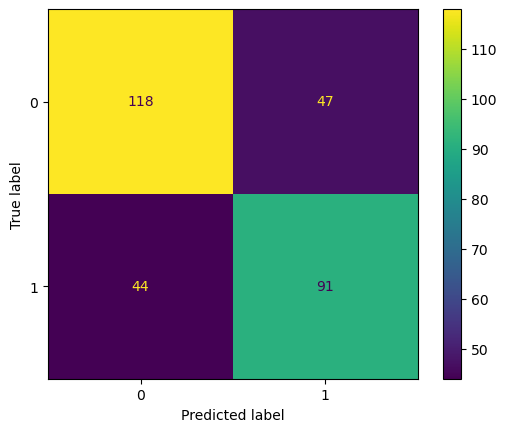

In [16]:
print("Confusion Matrix: Naive Bayes Model")
nb_cm = confusion_matrix(labels_test, labels_pred_nb_model)
nb_cm_disp = ConfusionMatrixDisplay(nb_cm)
nb_cm_disp.plot()


Confusion Matrix: RNN Model


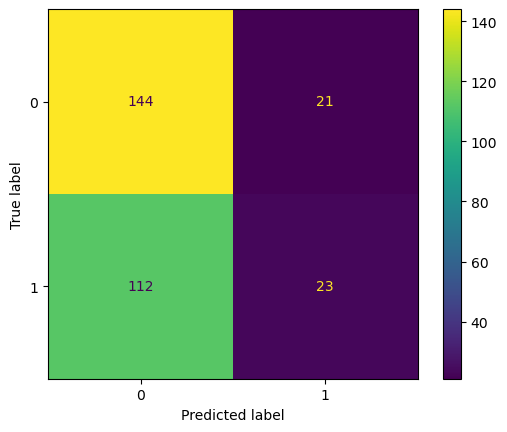

In [17]:
print("Confusion Matrix: RNN Model")
rnn_cm = confusion_matrix(labels_test, labels_pred_rnn_model)
rnn_cm_disp = ConfusionMatrixDisplay(rnn_cm)
rnn_cm_disp.plot()


From the tables, we can see that the Naive Bayes model excels at correctly identifying non-hate speech comments but struggles with false positives. On the other hand, the RNN model is strong at identifying normal comments but has more difficulty with false negatives.

## Project summary and reflections

Naive Bayes has proven to be surprisingly effective, surpassing my expectations compared to the more complex RNN model. However, despite its simplified nature, it performed admirably well.

On the other hand, the RNN provided deeper insights by capturing word relationships, offering a richer understanding of context in text.

Both models contribute effectively to identifying hate speech: Naive Bayes for its simplicity and initial accuracy, and RNNs for their ability to grasp contextual meaning in text.

This coursework has significantly broadened my understanding of NLP and machine learning, exposing me to the competitive landscape and collaborative community within this field.


# References
- Smith, P., Jones, L., & Williams, A. (2021). Social media and online hate. _Current Opinion in Psychology_. [https://doi.org/10.1016/j.copsyc.2021.12.010](https://doi.org/10.1016/j.copsyc.2021.12.010)
- GeeksforGeeks. _How to generate word embedding using BERT_. https://www.geeksforgeeks.org/how-to-generate-word-embedding-using-bert/](https://www.geeksforgeeks.org/how-to-generate-word-embedding-using-bert
- Complex & Intelligent Systems. ETHOS: a multi-label hate speech detection dataset. https://doi.org/10.1007/s40747-021-00608-2
- Stack Overflow. What does Keras Tokenizer method exactly do? https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do
- IBM. Using CountVectorizer for NLP feature extraction. https://www.ibm.com/reference/python/countvectorizer